In [3]:
import sys


sys.path.insert(0, "/Users/sumanta/Github/extensions/granite-tsfm")

In [4]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction

In [5]:
def generate_data(
    context_length, n_channels=1, min_ma_window=5, max_ma_window=20, scale=1.0, random_type="normal", seed=None
):
    rng = np.random.default_rng(seed=seed)
    pad = max(context_length // 2, max_ma_window + 1)
    effective_length = 2 * pad + context_length
    data = []
    min_ma_window = min(effective_length // 4, min_ma_window)
    max_ma_window = max(min(max_ma_window, context_length), 2 * min_ma_window)

    if random_type == "normal":
        generator_fn = partial(rng.normal, loc=0.0, scale=1.0)

        def w_scale(z):
            return 1.0
    elif random_type == "uniform":
        generator_fn = partial(rng.random)

        def w_scale(z):
            return 1 / (z + 1)
    else:
        raise ValueError(f"Error: unsupported {random_type=}")

    for i in range(n_channels):
        w = rng.integers(min_ma_window, max_ma_window)
        x = np.convolve(generator_fn(size=effective_length) * scale, np.ones(w) * w_scale(w), "same")
        data.append(x)
    return np.array(data).T[pad : (pad + context_length)]

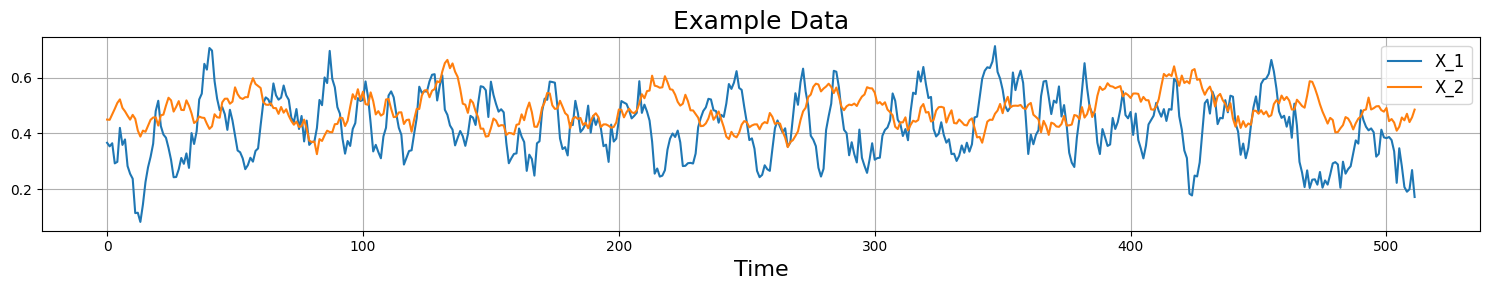

In [6]:
x = generate_data(512, n_channels=2, random_type="uniform", seed=42)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for i in range(x.shape[1]):
    ax.plot(x[:, i], label=f"X_{i + 1}")
ax.legend(fontsize=12)
ax.set_xlabel("Time", fontsize=16)
ax.set_title("Example Data", fontsize=18)
ax.grid()
plt.tight_layout()

In [7]:
path_to_tspulse_model = "ibm-granite/granite-timeseries-tspulse-r1"
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    path_to_tspulse_model,
    num_input_channels=2,
    revision="main",
    mask_type="user",
)

In [8]:
import torch


past_values = torch.from_numpy(x[np.newaxis, ...]).float()
patch_size = zeroshot_model.config.patch_length
reconstruct_start = 512 - 64
reconstruct_end = 512
separation = 4  # num_patches # 4

In [9]:
B, L, C = past_values.shape
device = past_values.device
num_patches = L // patch_size

In [10]:
patch_indices = torch.arange(num_patches, device=device)
patch_starts = patch_indices * patch_size
patch_starts

tensor([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104,
        112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216,
        224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328,
        336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464, 472, 480, 488, 496, 504])

In [11]:
valid_mask = (patch_starts >= reconstruct_start) & (patch_starts < reconstruct_end)
valid_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True])

In [12]:
selected_patch_indices = patch_indices[valid_mask]
num_selected_patches = selected_patch_indices.shape[0]
patch_schedule = []

for p in range(separation):
    schedule = [patch_starts[selected_patch_indices[i]] for i in range(p, num_selected_patches, separation)]
    if len(schedule) > 0:
        patch_schedule.append(schedule)

num_selected_patches_ = len(patch_schedule)

In [13]:
past_values_expanded = past_values.unsqueeze(1).repeat(1, num_selected_patches_, 1, 1)
past_values_expanded = past_values_expanded.view(B * num_selected_patches_, L, C)
past_values_expanded.shape

torch.Size([4, 512, 2])

In [14]:
past_observed_mask = torch.ones_like(past_values, dtype=torch.bool)
past_observed_mask = past_observed_mask.unsqueeze(1).repeat(1, num_selected_patches_, 1, 1)
past_observed_mask = past_observed_mask.view(B * num_selected_patches_, L, C)

In [15]:
patch_starts_selected = patch_starts[valid_mask]
for i, patch in enumerate(patch_schedule):
    b_indices = torch.arange(B, device=device)
    flat_idx = b_indices * num_selected_patches_ + i
    for start in patch:
        idx_range = slice(start.item(), start.item() + patch_size)
        past_observed_mask[flat_idx, idx_range, :] = 0  # Mask the patch

In [16]:
def patchwise_stitched_reconstruction_with_separation(
    model,
    past_values,
    patch_size,
    keys_to_stitch,
    keys_to_aggregate,
    reconstruct_start,
    reconstruct_end,
    separation=None,
    debug=False,
):
    """
    Performs patchwise reconstruction within a specified time window on a multivariate time-series tensor.
    Only patches whose **start indices fall within** [reconstruct_start, reconstruct_end) are masked and reconstructed.
    Results are then stitched or aggregated across the specified keys.

    Args:
        model: A callable that accepts `past_values` and `past_observed_mask` and returns a dict of outputs.
        past_values (torch.Tensor): Input tensor of shape [B, L, C], where
                                    B = batch size,
                                    L = sequence length,
                                    C = number of input channels.
        patch_size (int): Size of each non-overlapping patch.
        keys_to_stitch (List[str]): Keys in the model output dict that should be reconstructed and stitched
                                    back into full time-series format (shape [B, L, C]).
        keys_to_aggregate (List[str]): Keys in the model output dict that should be aggregated (mean-pooled)
                                       across patches (resulting in shape [B, ...]).
        reconstruct_start (int): Start index (inclusive) of the reconstruction window.
        reconstruct_end (int): End index (exclusive) of the reconstruction window.
        separation (int): Optional separation parameter used for faster evaluation
        debug (bool): If True, also returns patch-level outputs and patch indices.

    Returns:
        result_dict (dict): Dictionary containing:
            - For each key in `keys_to_stitch`: Reconstructed and stitched tensor of shape [B, L, C],
              with reconstructed values only in the patchwise regions; rest is filled with NaNs.
            - For each key in `keys_to_aggregate`: Aggregated (mean) tensor of shape [B, ...].

        If `debug=True`, also returns:
            patch_outputs (dict):
                - For each stitched key: Tensor of shape [B, num_selected_patches, patch_size, C],
                  which contains patch-level reconstructed outputs.
                - For each aggregated key: Tensor of shape [B, num_selected_patches, ...],
                  representing the output for each patch before aggregation.
                - "patch_starts_selected" (torch.Tensor): 1D tensor of shape [num_selected_patches]
                  with the start positions of each selected patch (in original time indices).

    Raises:
        ValueError: If no patches fall within the reconstruction window.
    """

    B, L, C = past_values.shape
    device = past_values.device
    num_patches = L // patch_size
    if separation is None:
        separation = num_patches
    separation = min(max(separation, 2), num_patches)

    patch_indices = torch.arange(num_patches, device=device)
    patch_starts = patch_indices * patch_size
    # patch_ends = patch_starts + patch_size

    # Select only patches fully inside the reconstruct window
    valid_mask = (patch_starts >= reconstruct_start) & (patch_starts < reconstruct_end)

    selected_patch_indices = patch_indices[valid_mask]
    num_selected_patches = selected_patch_indices.shape[0]

    if num_selected_patches == 0:
        raise ValueError("No patches fall entirely within the reconstruction window.")

    patch_schedule = []

    for p in range(separation):
        schedule = [patch_starts[selected_patch_indices[i]] for i in range(p, num_selected_patches, separation)]
        if len(schedule) > 0:
            patch_schedule.append(schedule)
    num_selected_patches = len(patch_schedule)

    # Step 1: Create expanded inputs → shape: [B * num_selected_patches, L, C]
    past_values_expanded = past_values.unsqueeze(1).repeat(1, num_selected_patches, 1, 1)
    past_values_expanded = past_values_expanded.view(B * num_selected_patches, L, C)

    # Step 2: Create past_observed_mask: [B * num_selected_patches, L, C]
    past_observed_mask = torch.ones_like(past_values, dtype=torch.bool)
    past_observed_mask = past_observed_mask.unsqueeze(1).repeat(1, num_selected_patches, 1, 1)
    past_observed_mask = past_observed_mask.view(B * num_selected_patches, L, C)

    patch_starts_selected = patch_starts[valid_mask]
    for i, patch in enumerate(patch_schedule):
        b_indices = torch.arange(B, device=device)
        flat_idx = b_indices * num_selected_patches + i
        for start in patch:
            idx_range = slice(start.item(), start.item() + patch_size)
            past_observed_mask[flat_idx, idx_range, :] = 0  # Mask the patch

    # Step 3: Forward pass
    model_outputs = model(
        past_values=past_values_expanded,
        past_observed_mask=past_observed_mask,
    )

    # Step 5: Initialize result dict
    result_dict = {key: torch.full_like(past_values, float("nan")) for key in keys_to_stitch}
    patch_outputs = {}

    # Step 6: Stitch keys
    for key in keys_to_stitch:
        output = model_outputs[key]  # [B * num_selected_patches, L, C]
        for i, patch in enumerate(patch_schedule):
            b_indices = torch.arange(B, device=device)
            flat_idx = b_indices * num_selected_patches + i
            for start in patch:
                idx_range = slice(start.item(), start.item() + patch_size)
                result_dict[key][:, idx_range, :] = output[flat_idx, idx_range]

    for key in keys_to_aggregate:
        output = model_outputs[key]  # [B * num_selected_patches, ...]
        out_shape = output.shape[1:]
        output = output.view(B, num_selected_patches, *out_shape)
        mean_output = output.mean(dim=1)
        result_dict[key] = mean_output
        if debug:
            patch_outputs[key] = output  # [B, num_selected_patches, ...]

    if debug:
        patch_outputs["patch_starts_selected"] = patch_starts_selected
        return result_dict, patch_outputs
    else:
        return result_dict

In [19]:
%%timeit
separation_list = [None]  # [None, 16, 14, 12, 10, 8, 6, 4]
results = {}

aggr_window = 8 * 64

with torch.no_grad():
    for i, s in enumerate(separation_list):
        result = patchwise_stitched_reconstruction_with_separation(
            zeroshot_model.cpu(),
            past_values.cpu(),
            8,
            ["reconstruction_outputs", "reconstructed_ts_from_fft"],
            ["forecast_output"],
            512 - aggr_window,
            512,
            separation=s,
        )
        result = {k: result[k].detach().cpu().numpy() for k in result.keys()}
        results[str(s)] = result

54.4 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
start = zeroshot_model.config.context_length - aggr_window
end = zeroshot_model.config.context_length

NameError: name 'aggr_window' is not defined

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))


axs[0].plot(x[start:end, 0], color="gray", linewidth=2, label="original")
axs[1].plot(x[start:end, 0], color="gray", linewidth=2, label="original")

for s in results:
    axs[0].plot(results[s]["reconstruction_outputs"][0, start:end, 0], label=s)
    axs[1].plot(results[s]["reconstructed_ts_from_fft"][0, start:end, 0], label=s)
for ax in axs.flat:
    ax.legend()

In [21]:
aggr_window

NameError: name 'aggr_window' is not defined